# Neural Networks for Time Series Forecasting
## From MLPs to RNNs, LSTMs, and GRUs

**Duration:** 60 minutes  
**Topics:** Multi-Layer Perceptrons, Recurrent Neural Networks, Long Short-Term Memory, Gated Recurrent Units

---

### Learning Objectives
1. Understand how different neural architectures handle time series data
2. Compare windowed (MLP) vs sequential (RNN/LSTM/GRU) approaches
3. Learn when to use each architecture for forecasting problems
4. Hands-on implementation and performance comparison

---
## Section 1: Setup and Data Preparation (5 minutes)

Let's start by importing our libraries and creating a realistic time series dataset.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Setup device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA version: {torch.version.cuda}")
else:
    print("ℹ️  Running on CPU (GPU not available)")

✓ Libraries imported successfully
✓ PyTorch version: 2.9.0+cu126
✓ Device: cuda
✓ GPU: NVIDIA GeForce RTX 4080 Laptop GPU
✓ CUDA version: 12.6


### Generate Synthetic load Data

We'll create hourly load data with:
- **Yearly seasonality** (summer hot, winter cold)
- **Daily patterns** (cooler at night, warmer during day)
- **Weekly patterns** (slight variations)
- **Trend** (slight warming over time)
- **Noise** (real-world variability)

In [ ]:
df = pd.read_csv("AEP_hourly.csv/AEP_hourly.csv")
df.rename(columns={"Datetime": "date", "AEP_MW": "load"}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df = df.tail(26280).reset_index(drop=True)

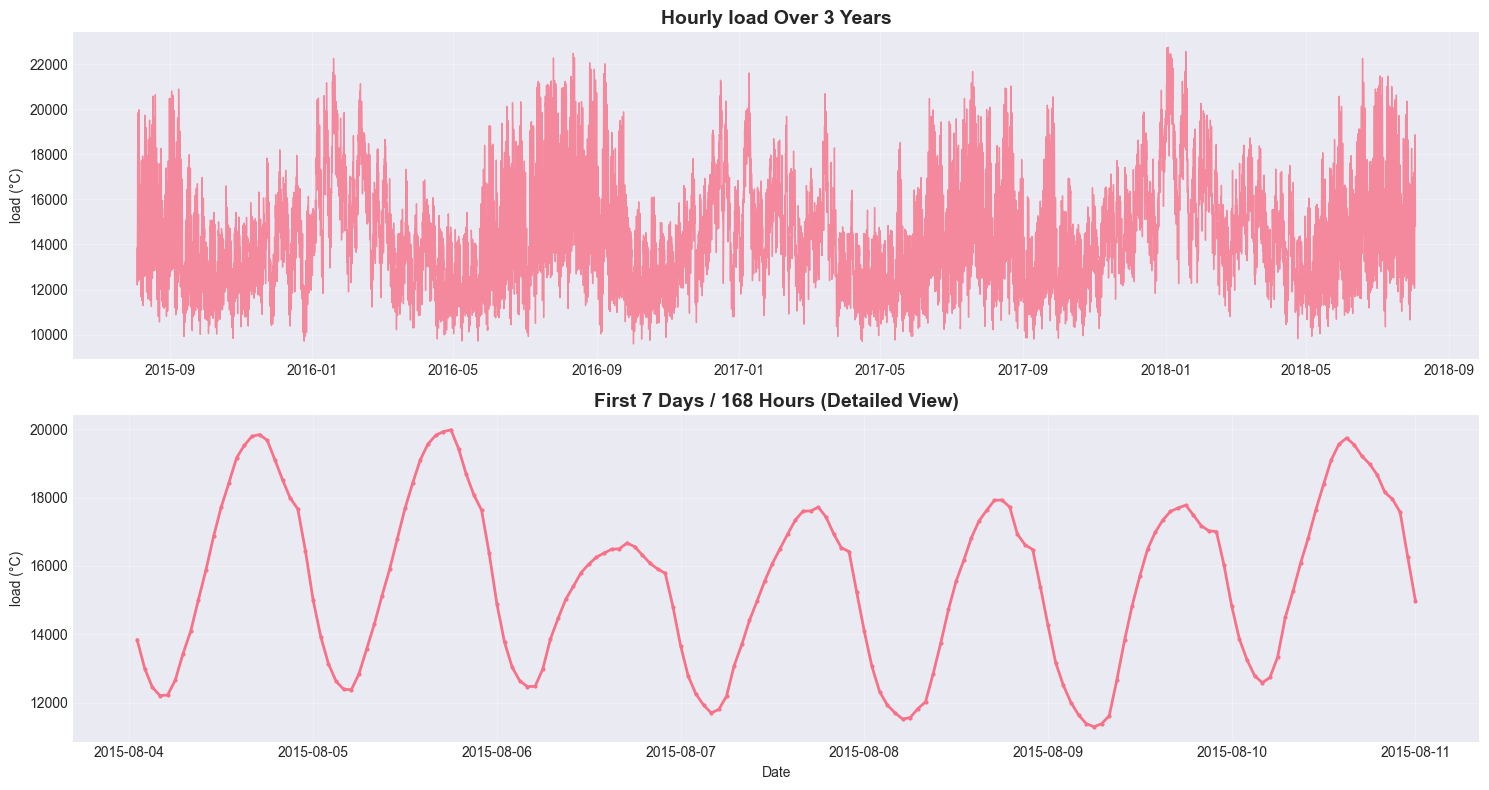

load statistics:
  Mean: 14679.54°C
  Std:  2448.37°C
  Min:  9581.00°C
  Max:  22759.00°C


In [ ]:
# Visualize the time series
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Full time series
axes[0].plot(df['date'], df['load'], linewidth=1, alpha=0.8)
axes[0].set_title('Hourly load Over 3 Years', fontsize=14, fontweight='bold')
axes[0].set_ylabel('load (°C)')
axes[0].grid(True, alpha=0.3)

# Zoom into first 7 days (168 hours)
axes[1].plot(df['date'][:168], df['load'][:168], linewidth=2, marker='o', markersize=2)
axes[1].set_title('First 7 Days / 168 Hours (Detailed View)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('load (°C)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"load statistics:")
print(f"  Mean: {df['load'].mean():.2f}°C")
print(f"  Std:  {df['load'].std():.2f}°C")
print(f"  Min:  {df['load'].min():.2f}°C")
print(f"  Max:  {df['load'].max():.2f}°C")

### Prepare Data for Training

**Critical for time series:**
- ✅ **Chronological split** (not random!)
- ✅ **Scale on training data only** (prevent data leakage)
- ✅ **Create sequences** for models

In [ ]:
# Train/Val/Test split (70/15/15)
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))

train_data = df['load'].values[:train_size]
val_data = df['load'].values[train_size:train_size + val_size]
test_data = df['load'].values[train_size + val_size:]

print(f"Train set: {len(train_data)} hours ({len(train_data)/24:.1f} days)")
print(f"Val set:   {len(val_data)} hours ({len(val_data)/24:.1f} days)")
print(f"Test set:  {len(test_data)} hours ({len(test_data)/24:.1f} days)")

# Scale data (fit scaler on training data only!)
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
val_scaled = scaler.transform(val_data.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()

print("\n✓ Data scaled successfully")

Train set: 18396 hours (766.5 days)
Val set:   3942 hours (164.2 days)
Test set:  3942 hours (164.2 days)

✓ Data scaled successfully


In [ ]:
def create_sequences(data, seq_length, forecast_horizon=1):
    """
    Create sequences for time series forecasting.

    Args:
        data: input time series
        seq_length: number of past timesteps to use
        forecast_horizon: number of future timesteps to predict

    Returns:
        X: sequences of shape (n_samples, seq_length)
        y: targets of shape (n_samples, forecast_horizon)
    """
    X, y = [], []

    for i in range(len(data) - seq_length - forecast_horizon + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + forecast_horizon])

    return np.array(X), np.array(y)

# Parameters - BACK TO WORKING SETTINGS
SEQ_LENGTH = 168  # Use 7 days (168 hours) of history to predict future
FORECAST_HORIZON = 12  # Predict next 1 hour
BATCH_SIZE = 32

# Create sequences
X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH, FORECAST_HORIZON)
X_val, y_val = create_sequences(val_scaled, SEQ_LENGTH, FORECAST_HORIZON)
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH, FORECAST_HORIZON)

print(f"\nSequence shapes:")
print(f"X_train: {X_train.shape} (samples, seq_length)")
print(f"y_train: {y_train.shape} (samples, forecast_horizon)")
print(f"\nInterpretation: Use {SEQ_LENGTH} past hours ({SEQ_LENGTH/24:.1f} days) to predict next {FORECAST_HORIZON} hours ({FORECAST_HORIZON/24:.1f} days)")


Sequence shapes:
X_train: (18217, 168) (samples, seq_length)
y_train: (18217, 12) (samples, forecast_horizon)

Interpretation: Use 168 past hours (7.0 days) to predict next 12 hours (0.5 days)


---
## Section 2: Multi-Layer Perceptrons (MLPs) for Time Series (8 minutes)

### The Windowed Approach

MLPs treat time series as:
- **Input:** Fixed window of past values [t-168, t-167, ..., t-1] (7 days of hourly data)
- **Output:** Future value(s) [t, t+1, ..., t+167] (next 7 days hourly)

**Pros:**
- ✅ Simple and fast
- ✅ Works well for short-term patterns

**Cons:**
- ❌ No explicit temporal modeling
- ❌ Fixed window size
- ❌ Order doesn't matter to the network

### MLP Architecture Diagram

**TODO: Add your MLP architecture image here**

To add your image:
1. Place your image file in the same directory as this notebook (e.g., `mlp_architecture.png`)
2. Replace this cell with: `![MLP Architecture](mlp_architecture.png)`

Or use this code in a code cell to display it:
```python
from IPython.display import Image, display
display(Image('mlp_architecture.png', width=600))
```

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        return self.network(x)

# Initialize model
mlp_model = MLP(input_size=SEQ_LENGTH, hidden_size=64, output_size=FORECAST_HORIZON)
print(summary(mlp_model, input_size=(1, SEQ_LENGTH)))  # (batch_size, input_features)
print(f"\nTotal parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")


Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 12]                   --
├─Sequential: 1-1                        [1, 12]                   --
│    └─Linear: 2-1                       [1, 64]                   10,816
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Dropout: 2-3                      [1, 64]                   --
│    └─Linear: 2-4                       [1, 32]                   2,080
│    └─ReLU: 2-5                         [1, 32]                   --
│    └─Dropout: 2-6                      [1, 32]                   --
│    └─Linear: 2-7                       [1, 12]                   396
Total params: 13,292
Trainable params: 13,292
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05

Total parameters: 13,292


In [ ]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=30, lr=0.001, batch_size=32):
    """
    SIMPLE training function - back to basics!
    """
    # Move model to device
    model = model.to(device)

    # Convert to PyTorch tensors and move to device
    X_train_t = torch.FloatTensor(X_train).to(device)
    y_train_t = torch.FloatTensor(y_train).to(device)
    X_val_t = torch.FloatTensor(X_val).to(device)
    y_val_t = torch.FloatTensor(y_val).to(device)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Setup training - SIMPLE
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()

            # Only gradient clipping - nothing else
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            epoch_loss += loss.item()

        # Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_t)
            val_loss = criterion(val_pred, y_val_t).item()

        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

In [ ]:
def evaluate_model(model, X_test, y_test, scaler, model_name="Model"):
    """
    Evaluate model and compute metrics (GPU-enabled)
    """
    model.eval()
    model = model.to(device)

    with torch.no_grad():
        X_test_t = torch.FloatTensor(X_test).to(device)
        predictions = model(X_test_t).cpu().numpy()

    # Inverse transform
    y_test_actual = scaler.inverse_transform(y_test)
    predictions_actual = scaler.inverse_transform(predictions)

    # Compute metrics for each forecast horizon
    rmse_per_horizon = []
    mae_per_horizon = []

    for h in range(y_test.shape[1]):
        rmse = np.sqrt(mean_squared_error(y_test_actual[:, h], predictions_actual[:, h]))
        mae = mean_absolute_error(y_test_actual[:, h], predictions_actual[:, h])
        rmse_per_horizon.append(rmse)
        mae_per_horizon.append(mae)

    print(f"\n{model_name} Test Results:")
    print(f"  Average RMSE: {np.mean(rmse_per_horizon):.3f}°C")
    print(f"  Average MAE:  {np.mean(mae_per_horizon):.3f}°C")

    return predictions_actual, y_test_actual, rmse_per_horizon, mae_per_horizon

In [ ]:
# Train MLP
print("Training MLP...\n")
mlp_train_losses, mlp_val_losses = train_model(mlp_model, X_train, y_train, X_val, y_val, epochs=10)

Training MLP...

Epoch [10/10] - Train Loss: 0.0178, Val Loss: 0.0141


In [ ]:
# Evaluate MLP
mlp_preds, mlp_actuals, mlp_rmse, mlp_mae = evaluate_model(mlp_model, X_test, y_test, scaler, "MLP")


MLP Test Results:
  Average RMSE: 701.310°C
  Average MAE:  551.232°C


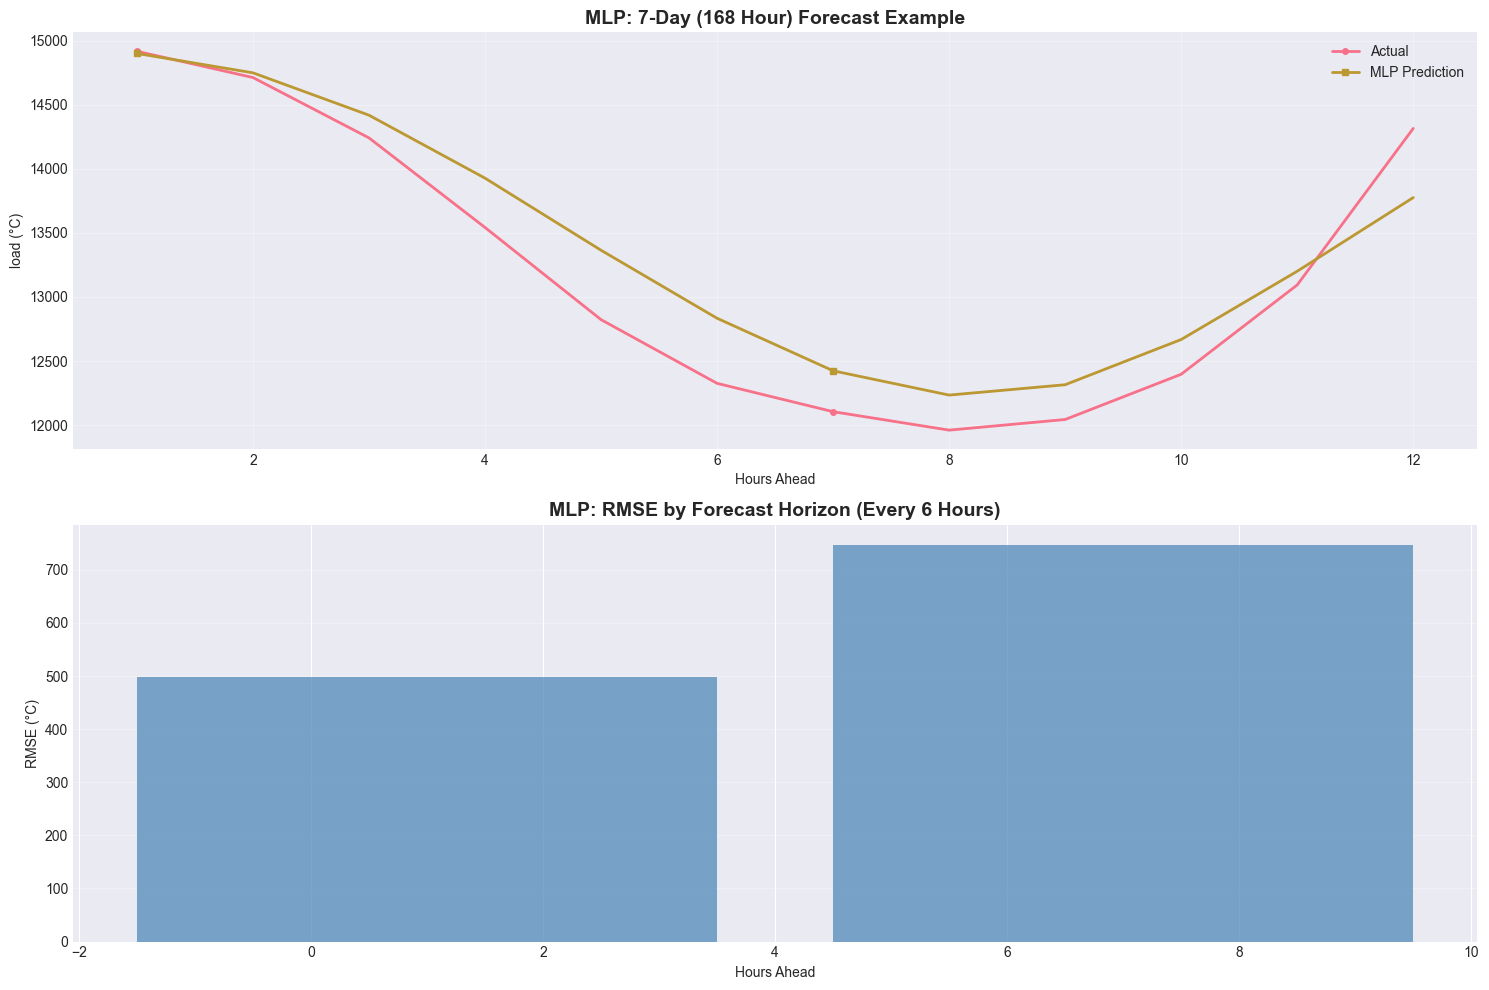


📊 Observation: Notice how error typically increases for longer horizons


In [ ]:
# Visualize MLP predictions
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Sample predictions
sample_idx = 50
hours_ahead = np.arange(1, FORECAST_HORIZON + 1)

axes[0].plot(hours_ahead, mlp_actuals[sample_idx], 'o-', label='Actual', linewidth=2, markersize=4, markevery=6)
axes[0].plot(hours_ahead, mlp_preds[sample_idx], 's-', label='MLP Prediction', linewidth=2, markersize=4, markevery=6)
axes[0].set_title('MLP: 7-Day (168 Hour) Forecast Example', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hours Ahead')
axes[0].set_ylabel('load (°C)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE by forecast horizon (show every 6th hour for readability)
axes[1].bar(hours_ahead[::6], np.array(mlp_rmse)[::6], alpha=0.7, color='steelblue', width=5)
axes[1].set_title('MLP: RMSE by Forecast Horizon (Every 6 Hours)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hours Ahead')
axes[1].set_ylabel('RMSE (°C)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Observation: Notice how error typically increases for longer horizons")

### 💭 Discussion Point

**Question for students:** What happens if we shuffle the input sequence [t-30, t-29, ..., t-1]? Would the MLP care?

**Answer:** No! MLPs treat each timestep as an independent feature. The temporal order is lost.

**This motivates RNNs →** We need architectures that understand time!

---
## Section 3: Recurrent Neural Networks (RNNs) (12 minutes)

### Why RNNs?

RNNs process sequences **one timestep at a time**, maintaining a **hidden state** that captures information from previous timesteps.

**Key concept:** Hidden state = memory of what the network has seen so far

```
h_t = tanh(W_hh * h_{t-1} + W_xh * x_t + b_h)
y_t = W_hy * h_t + b_y
```

**Pros:**
- ✅ Explicitly models temporal dependencies
- ✅ Can handle variable-length sequences
- ✅ Parameter sharing across time

**Cons:**
- ❌ Vanishing/exploding gradients for long sequences
- ❌ Difficulty learning long-term dependencies

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

---
## 🔬 Exercise 1: RNN vs MLP Comparison (12 minutes)

Let's implement an RNN and compare it directly with our MLP!

In [ ]:
class RNNForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=168, num_layers=2, output_size=7):
        super(RNNForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, seq_len)
        # Reshape to (batch, seq_len, features)
        x = x.unsqueeze(-1)

        # RNN forward pass
        # out shape: (batch, seq_len, hidden_size)
        # h_n shape: (num_layers, batch, hidden_size)
        out, h_n = self.rnn(x)

        # Use the last hidden state
        # out[:, -1, :] gets the last timestep's output
        last_hidden = out[:, -1, :]

        # Predict future values
        predictions = self.fc(last_hidden)
        return predictions

# Initialize RNN
rnn_model = RNNForecaster(input_size=1, hidden_size=64, num_layers=2, output_size=FORECAST_HORIZON)
print(summary(rnn_model, input_size=(1,1)))
print(f"\nTotal parameters: {sum(p.numel() for p in rnn_model.parameters()):,}")

Layer (type:depth-idx)                   Output Shape              Param #
RNNForecaster                            [1, 12]                   --
├─RNN: 1-1                               [1, 1, 64]                12,608
├─Linear: 1-2                            [1, 12]                   780
Total params: 13,388
Trainable params: 13,388
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05

Total parameters: 13,388


In [ ]:
# Train RNN
print("Training RNN...\n")
rnn_train_losses, rnn_val_losses = train_model(rnn_model, X_train, y_train, X_val, y_val, epochs=10)

Training RNN...

Epoch [10/10] - Train Loss: 0.0122, Val Loss: 0.0167


In [ ]:
# Evaluate RNN
rnn_preds, rnn_actuals, rnn_rmse, rnn_mae = evaluate_model(rnn_model, X_test, y_test, scaler, "RNN")


RNN Test Results:
  Average RMSE: 720.930°C
  Average MAE:  565.120°C


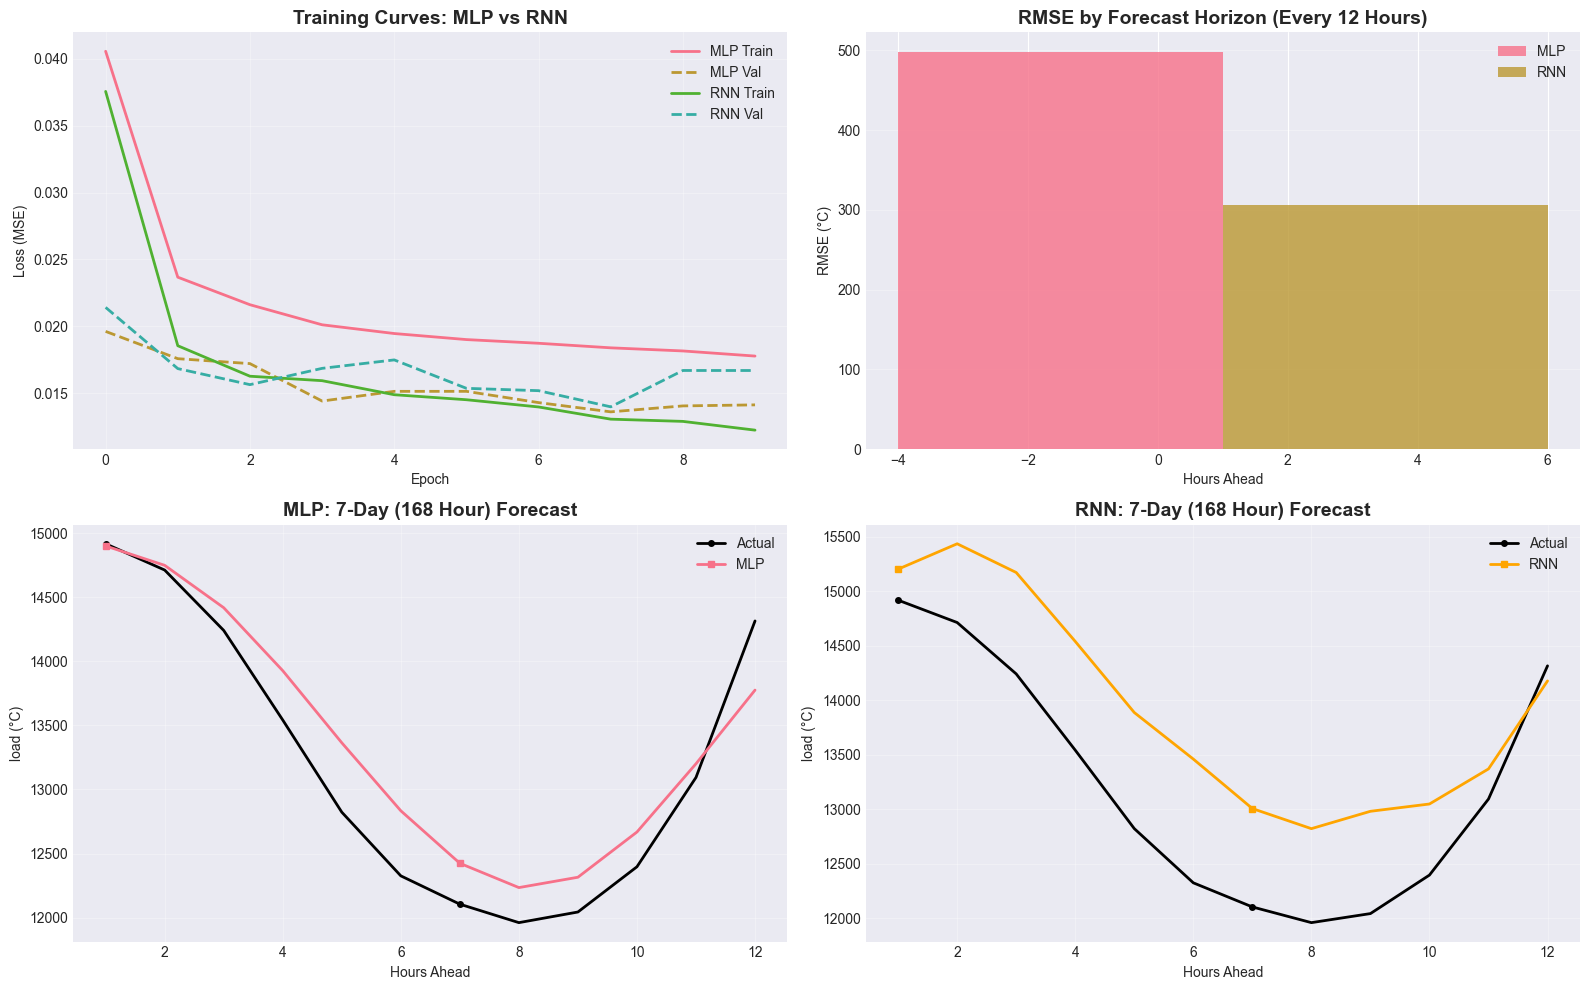


📊 MLP vs RNN Performance Summary
Metric               MLP             RNN             Winner
------------------------------------------------------------
Avg RMSE (°C)        701.310         720.930         MLP
Avg MAE (°C)         551.232         565.120         MLP
Parameters           13,292          13,388         


In [ ]:
# Compare MLP vs RNN
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Training curves
axes[0, 0].plot(mlp_train_losses, label='MLP Train', linewidth=2)
axes[0, 0].plot(mlp_val_losses, label='MLP Val', linewidth=2, linestyle='--')
axes[0, 0].plot(rnn_train_losses, label='RNN Train', linewidth=2)
axes[0, 0].plot(rnn_val_losses, label='RNN Val', linewidth=2, linestyle='--')
axes[0, 0].set_title('Training Curves: MLP vs RNN', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# RMSE comparison (show every 12th hour for readability)
x = np.arange(1, FORECAST_HORIZON + 1)
x_ticks = x[::12]  # Every 12 hours
width = 5
axes[0, 1].bar(x_ticks - width/2, np.array(mlp_rmse)[::12], width, label='MLP', alpha=0.8)
axes[0, 1].bar(x_ticks + width/2, np.array(rnn_rmse)[::12], width, label='RNN', alpha=0.8)
axes[0, 1].set_title('RMSE by Forecast Horizon (Every 12 Hours)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Hours Ahead')
axes[0, 1].set_ylabel('RMSE (°C)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Sample predictions - MLP
sample_idx = 50
hours_ahead = np.arange(1, FORECAST_HORIZON + 1)
axes[1, 0].plot(hours_ahead, mlp_actuals[sample_idx], 'ko-', label='Actual', linewidth=2, markersize=4, markevery=6)
axes[1, 0].plot(hours_ahead, mlp_preds[sample_idx], 's-', label='MLP', linewidth=2, markersize=4, markevery=6)
axes[1, 0].set_title('MLP: 7-Day (168 Hour) Forecast', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hours Ahead')
axes[1, 0].set_ylabel('load (°C)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Sample predictions - RNN
axes[1, 1].plot(hours_ahead, rnn_actuals[sample_idx], 'ko-', label='Actual', linewidth=2, markersize=4, markevery=6)
axes[1, 1].plot(hours_ahead, rnn_preds[sample_idx], 's-', label='RNN', linewidth=2, markersize=4, markevery=6, color='orange')
axes[1, 1].set_title('RNN: 7-Day (168 Hour) Forecast', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Hours Ahead')
axes[1, 1].set_ylabel('load (°C)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("📊 MLP vs RNN Performance Summary")
print("="*60)
print(f"{'Metric':<20} {'MLP':<15} {'RNN':<15} {'Winner'}")
print("-"*60)
print(f"{'Avg RMSE (°C)':<20} {np.mean(mlp_rmse):<15.3f} {np.mean(rnn_rmse):<15.3f} {'RNN' if np.mean(rnn_rmse) < np.mean(mlp_rmse) else 'MLP'}")
print(f"{'Avg MAE (°C)':<20} {np.mean(mlp_mae):<15.3f} {np.mean(rnn_mae):<15.3f} {'RNN' if np.mean(rnn_mae) < np.mean(mlp_mae) else 'MLP'}")
print(f"{'Parameters':<20} {sum(p.numel() for p in mlp_model.parameters()):<15,} {sum(p.numel() for p in rnn_model.parameters()):<15,}")
print("="*60)

### 💭 Discussion Points

1. **Which model performs better?** Why?
2. **Look at the forecast horizon:** Does error grow differently for MLP vs RNN?
3. **Training dynamics:** Which model converges faster?

### The Vanishing Gradient Problem

RNNs struggle with **long-term dependencies** because:
- Gradients are multiplied through many timesteps during backpropagation
- Gradients can vanish (→ 0) or explode (→ ∞)
- Network can't learn patterns spanning many timesteps

**Solution?** → LSTMs and GRUs!

---
## Section 4: Long Short-Term Memory (LSTM) Networks (15 minutes)

### The LSTM Architecture

LSTMs solve the vanishing gradient problem with a sophisticated **gating mechanism**:

**Three gates:**
1. **Forget Gate (f):** What to discard from cell state
2. **Input Gate (i):** What new information to add
3. **Output Gate (o):** What to output based on cell state

**Key innovation:** Cell state (C_t) - a highway for gradients!

```
f_t = σ(W_f · [h_{t-1}, x_t] + b_f)  # Forget gate
i_t = σ(W_i · [h_{t-1}, x_t] + b_i)  # Input gate
C̃_t = tanh(W_C · [h_{t-1}, x_t] + b_C)  # Candidate values
C_t = f_t * C_{t-1} + i_t * C̃_t      # Update cell state
o_t = σ(W_o · [h_{t-1}, x_t] + b_o)  # Output gate
h_t = o_t * tanh(C_t)                # Hidden state
```

**Pros:**
- ✅ Handles long-term dependencies
- ✅ Mitigates vanishing gradients
- ✅ State-of-the-art for many sequence tasks

**Cons:**
- ❌ More parameters (slower training)
- ❌ More complex architecture

### LSTM Architecture Diagram

**TODO: Add your LSTM architecture image here**

To add your image:
```python
from IPython.display import Image, display
display(Image('lstm_architecture.png', width=600))
```

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)

---
## 🔬 Exercise 2: LSTM for Multi-Step Forecasting (15 minutes)

Let's implement an LSTM and visualize its internal gates!

In [ ]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=7):
        super(LSTMForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer - SIMPLE
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, seq_len)
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)

        # LSTM forward
        out, (h_n, c_n) = self.lstm(x)

        # Use last timestep
        last_hidden = out[:, -1, :]

        # Predict future
        predictions = self.fc(last_hidden)
        return predictions

# Initialize LSTM - BACK TO SIMPLE
lstm_model = LSTMForecaster(input_size=1, hidden_size=64, num_layers=2, output_size=FORECAST_HORIZON)
print(lstm_model)
print(summary(lstm_model, input_size=(1,1)))
print(f"\nTotal parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")
print(f"\n💡 Note: LSTM has ~4x parameters per layer compared to RNN (due to gates)")

LSTMForecaster(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=12, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
LSTMForecaster                           [1, 12]                   --
├─LSTM: 1-1                              [1, 1, 64]                50,432
├─Linear: 1-2                            [1, 12]                   780
Total params: 51,212
Trainable params: 51,212
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.21

Total parameters: 51,212

💡 Note: LSTM has ~4x parameters per layer compared to RNN (due to gates)


In [ ]:
# Train LSTM - SIMPLE
print("Training LSTM...\n")
lstm_train_losses, lstm_val_losses = train_model(lstm_model, X_train, y_train, X_val, y_val, epochs=10)

Training LSTM...

Epoch [10/10] - Train Loss: 0.0103, Val Loss: 0.0122


In [ ]:
# Evaluate LSTM
lstm_preds, lstm_actuals, lstm_rmse, lstm_mae = evaluate_model(lstm_model, X_test, y_test, scaler, "LSTM")


LSTM Test Results:
  Average RMSE: 698.860°C
  Average MAE:  541.460°C


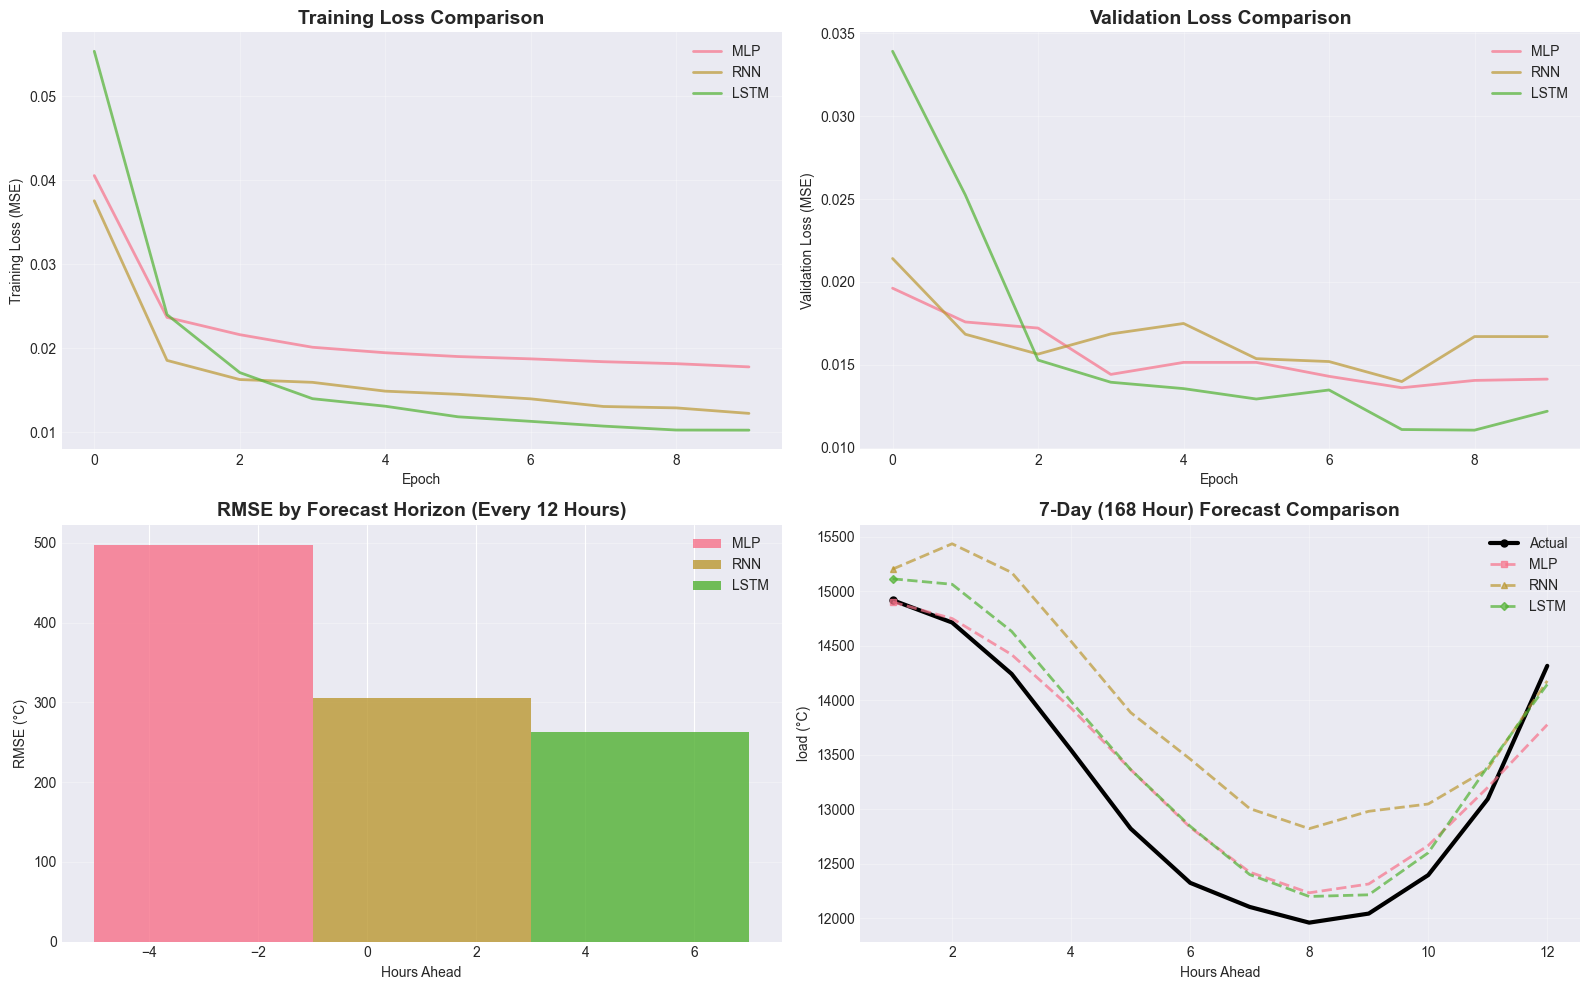


📊 Complete Performance Comparison
Metric                    MLP             RNN             LSTM           
----------------------------------------------------------------------
Avg RMSE (°C)             701.310         720.930         698.860        
Avg MAE (°C)              551.232         565.120         541.460        
Final Train Loss          0.0178          0.0122          0.0103         
Final Val Loss            0.0141          0.0167          0.0122         
Parameters                13,292          13,388          51,212         

💡 RNN improves over MLP by: -2.8%
💡 LSTM improves over MLP by: 0.3%


In [ ]:
# Three-way comparison: MLP vs RNN vs LSTM
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Training curves
axes[0, 0].plot(mlp_train_losses, label='MLP', linewidth=2, alpha=0.7)
axes[0, 0].plot(rnn_train_losses, label='RNN', linewidth=2, alpha=0.7)
axes[0, 0].plot(lstm_train_losses, label='LSTM', linewidth=2, alpha=0.7)
axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Training Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation curves
axes[0, 1].plot(mlp_val_losses, label='MLP', linewidth=2, alpha=0.7)
axes[0, 1].plot(rnn_val_losses, label='RNN', linewidth=2, alpha=0.7)
axes[0, 1].plot(lstm_val_losses, label='LSTM', linewidth=2, alpha=0.7)
axes[0, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Loss (MSE)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# RMSE by horizon (show every 12th hour for readability)
x = np.arange(1, FORECAST_HORIZON + 1)
x_ticks = x[::12]  # Every 12 hours
width = 4
axes[1, 0].bar(x_ticks - width, np.array(mlp_rmse)[::12], width, label='MLP', alpha=0.8)
axes[1, 0].bar(x_ticks, np.array(rnn_rmse)[::12], width, label='RNN', alpha=0.8)
axes[1, 0].bar(x_ticks + width, np.array(lstm_rmse)[::12], width, label='LSTM', alpha=0.8)
axes[1, 0].set_title('RMSE by Forecast Horizon (Every 12 Hours)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hours Ahead')
axes[1, 0].set_ylabel('RMSE (°C)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Sample predictions comparison
sample_idx = 50
hours_ahead = np.arange(1, FORECAST_HORIZON + 1)
axes[1, 1].plot(hours_ahead, lstm_actuals[sample_idx], 'ko-', label='Actual', linewidth=3, markersize=5, markevery=12)
axes[1, 1].plot(hours_ahead, mlp_preds[sample_idx], 's--', label='MLP', linewidth=2, markersize=4, alpha=0.7, markevery=12)
axes[1, 1].plot(hours_ahead, rnn_preds[sample_idx], '^--', label='RNN', linewidth=2, markersize=4, alpha=0.7, markevery=12)
axes[1, 1].plot(hours_ahead, lstm_preds[sample_idx], 'D--', label='LSTM', linewidth=2, markersize=4, alpha=0.7, markevery=12)
axes[1, 1].set_title('7-Day (168 Hour) Forecast Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Hours Ahead')
axes[1, 1].set_ylabel('load (°C)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print("📊 Complete Performance Comparison")
print("="*70)
print(f"{'Metric':<25} {'MLP':<15} {'RNN':<15} {'LSTM':<15}")
print("-"*70)
print(f"{'Avg RMSE (°C)':<25} {np.mean(mlp_rmse):<15.3f} {np.mean(rnn_rmse):<15.3f} {np.mean(lstm_rmse):<15.3f}")
print(f"{'Avg MAE (°C)':<25} {np.mean(mlp_mae):<15.3f} {np.mean(rnn_mae):<15.3f} {np.mean(lstm_mae):<15.3f}")
print(f"{'Final Train Loss':<25} {mlp_train_losses[-1]:<15.4f} {rnn_train_losses[-1]:<15.4f} {lstm_train_losses[-1]:<15.4f}")
print(f"{'Final Val Loss':<25} {mlp_val_losses[-1]:<15.4f} {rnn_val_losses[-1]:<15.4f} {lstm_val_losses[-1]:<15.4f}")
print(f"{'Parameters':<25} {sum(p.numel() for p in mlp_model.parameters()):<15,} {sum(p.numel() for p in rnn_model.parameters()):<15,} {sum(p.numel() for p in lstm_model.parameters()):<15,}")
print("="*70)

# Improvement percentages
improvement_rnn = ((np.mean(mlp_rmse) - np.mean(rnn_rmse)) / np.mean(mlp_rmse)) * 100
improvement_lstm = ((np.mean(mlp_rmse) - np.mean(lstm_rmse)) / np.mean(mlp_rmse)) * 100
print(f"\n💡 RNN improves over MLP by: {improvement_rnn:.1f}%")
print(f"💡 LSTM improves over MLP by: {improvement_lstm:.1f}%")

### 💭 Key Observations

1. **Training stability:** LSTMs typically have smoother training curves
2. **Long-term forecasting:** LSTMs excel at longer horizons (later hours in the forecast)
3. **Generalization:** Look at train vs validation gap

### When to Use LSTMs

**Use LSTMs when:**
- ✅ Long-term dependencies are critical
- ✅ You have sufficient training data
- ✅ Model complexity is not a constraint
- ✅ Forecasting far into the future (days/weeks/months)

**Example applications:**
- Financial market prediction
- Long-term energy demand forecasting
- Climate modeling

---
## Section 5: Gated Recurrent Units (GRUs) (12 minutes)

### The GRU Architecture

GRUs are a **simplified version of LSTMs** with fewer gates:

**Two gates instead of three:**
1. **Reset Gate (r):** How much past info to forget
2. **Update Gate (z):** How much to update with new info

**No separate cell state!** - Hidden state does double duty

```
z_t = σ(W_z · [h_{t-1}, x_t])      # Update gate
r_t = σ(W_r · [h_{t-1}, x_t])      # Reset gate
h̃_t = tanh(W · [r_t * h_{t-1}, x_t])  # Candidate
h_t = (1 - z_t) * h_{t-1} + z_t * h̃_t  # New hidden state
```

**Pros:**
- ✅ Fewer parameters than LSTM (~25% less)
- ✅ Faster training and inference
- ✅ Often comparable performance to LSTM
- ✅ Better for smaller datasets

**Cons:**
- ❌ Slightly less expressive than LSTM
- ❌ May underperform on very long sequences

### GRU Architecture Diagram

**TODO: Add your GRU architecture image here**

To add your image:
```python
from IPython.display import Image, display
display(Image('gru_architecture.png', width=600))
```

---
## 🔬 Exercise 3: GRU vs LSTM - Speed & Accuracy Trade-off (12 minutes)

Let's benchmark GRU against LSTM!

In [ ]:
class GRUForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=7):
        super(GRUForecaster, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU layer - SIMPLE
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, seq_len)
        x = x.unsqueeze(-1)  # (batch, seq_len, 1)

        # GRU forward
        out, h_n = self.gru(x)

        # Use last timestep
        last_hidden = out[:, -1, :]

        # Predict future
        predictions = self.fc(last_hidden)
        return predictions

# Initialize GRU - SIMPLE
gru_model = GRUForecaster(input_size=1, hidden_size=64, num_layers=2, output_size=FORECAST_HORIZON)
print(summary(gru_model, input_size=(1,1)))

print(f"\nTotal parameters: {sum(p.numel() for p in gru_model.parameters()):,}")

# Parameter comparison
print("\n" + "="*60)
print("Parameter Count Comparison:")
print("="*60)
print(f"MLP:  {sum(p.numel() for p in mlp_model.parameters()):>8,} parameters")
print(f"RNN:  {sum(p.numel() for p in rnn_model.parameters()):>8,} parameters")
print(f"GRU:  {sum(p.numel() for p in gru_model.parameters()):>8,} parameters")
print(f"LSTM: {sum(p.numel() for p in lstm_model.parameters()):>8,} parameters")
print("="*60)

Layer (type:depth-idx)                   Output Shape              Param #
GRUForecaster                            [1, 12]                   --
├─GRU: 1-1                               [1, 1, 64]                37,824
├─Linear: 1-2                            [1, 12]                   780
Total params: 38,604
Trainable params: 38,604
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16

Total parameters: 38,604

Parameter Count Comparison:
MLP:    13,292 parameters
RNN:    13,388 parameters
GRU:    38,604 parameters
LSTM:   51,212 parameters


In [ ]:
import time

# Train GRU - SIMPLE
print("Training GRU...\n")
start_time = time.time()
gru_train_losses, gru_val_losses = train_model(gru_model, X_train, y_train, X_val, y_val, epochs=10)
gru_train_time = time.time() - start_time

print(f"\n⏱️  GRU training time: {gru_train_time:.2f} seconds")

Training GRU...

Epoch [10/10] - Train Loss: 0.0097, Val Loss: 0.0105

⏱️  GRU training time: 11.36 seconds


In [ ]:
# Evaluate GRU
gru_preds, gru_actuals, gru_rmse, gru_mae = evaluate_model(gru_model, X_test, y_test, scaler, "GRU")


GRU Test Results:
  Average RMSE: 619.922°C
  Average MAE:  479.521°C


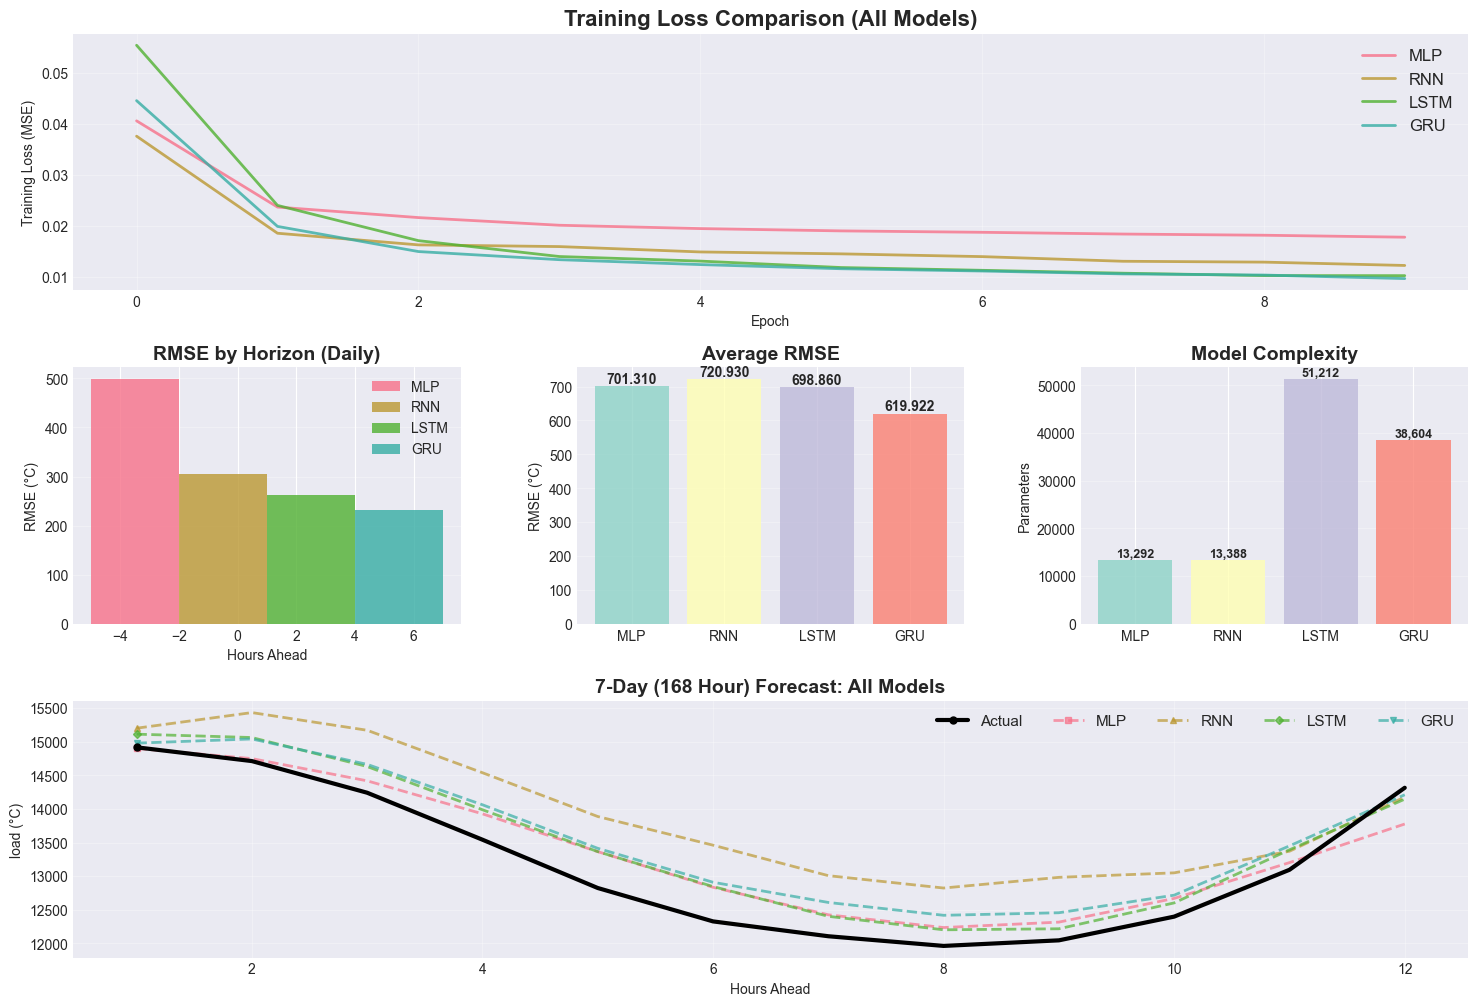


🏆 FINAL MODEL COMPARISON
Metric                         MLP             RNN             LSTM            GRU            
--------------------------------------------------------------------------------
Avg RMSE (°C)                  701.310         720.930         698.860         619.922        
Avg MAE (°C)                   551.232         565.120         541.460         479.521        
Parameters                     13,292          13,388          51,212          38,604         
Final Val Loss                 0.0141          0.0167          0.0122          0.0105         

🥇 Best performing model: GRU

💡 GRU vs LSTM:
   - LSTM has 12,608 more parameters (32.7% increase)
   - Performance difference: 78.937°C RMSE
   - GRU is better with fewer parameters!


In [ ]:
# Comprehensive comparison: All 4 models
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Training curves
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(mlp_train_losses, label='MLP', linewidth=2, alpha=0.8)
ax1.plot(rnn_train_losses, label='RNN', linewidth=2, alpha=0.8)
ax1.plot(lstm_train_losses, label='LSTM', linewidth=2, alpha=0.8)
ax1.plot(gru_train_losses, label='GRU', linewidth=2, alpha=0.8)
ax1.set_title('Training Loss Comparison (All Models)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss (MSE)')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# RMSE comparison (show every 24th hour for readability - one per day)
ax2 = fig.add_subplot(gs[1, 0])
x = np.arange(1, FORECAST_HORIZON + 1)
x_ticks = x[::24]  # Every 24 hours (one per day)
width = 3
ax2.bar(x_ticks - 1.5*width, np.array(mlp_rmse)[::24], width, label='MLP', alpha=0.8)
ax2.bar(x_ticks - 0.5*width, np.array(rnn_rmse)[::24], width, label='RNN', alpha=0.8)
ax2.bar(x_ticks + 0.5*width, np.array(lstm_rmse)[::24], width, label='LSTM', alpha=0.8)
ax2.bar(x_ticks + 1.5*width, np.array(gru_rmse)[::24], width, label='GRU', alpha=0.8)
ax2.set_title('RMSE by Horizon (Daily)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hours Ahead')
ax2.set_ylabel('RMSE (°C)')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Average performance
ax3 = fig.add_subplot(gs[1, 1])
models = ['MLP', 'RNN', 'LSTM', 'GRU']
avg_rmse = [np.mean(mlp_rmse), np.mean(rnn_rmse), np.mean(lstm_rmse), np.mean(gru_rmse)]
colors = plt.cm.Set3(range(4))
bars = ax3.bar(models, avg_rmse, color=colors, alpha=0.8)
ax3.set_title('Average RMSE', fontsize=14, fontweight='bold')
ax3.set_ylabel('RMSE (°C)')
ax3.grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, val in zip(bars, avg_rmse):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# Parameter count
ax4 = fig.add_subplot(gs[1, 2])
param_counts = [
    sum(p.numel() for p in mlp_model.parameters()),
    sum(p.numel() for p in rnn_model.parameters()),
    sum(p.numel() for p in lstm_model.parameters()),
    sum(p.numel() for p in gru_model.parameters())
]
bars = ax4.bar(models, param_counts, color=colors, alpha=0.8)
ax4.set_title('Model Complexity', fontsize=14, fontweight='bold')
ax4.set_ylabel('Parameters')
ax4.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar, val in zip(bars, param_counts):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Sample predictions - All models
ax5 = fig.add_subplot(gs[2, :])
sample_idx = 50
hours_ahead = np.arange(1, FORECAST_HORIZON + 1)
ax5.plot(hours_ahead, lstm_actuals[sample_idx], 'ko-', label='Actual', linewidth=3, markersize=5, markevery=12, zorder=5)
ax5.plot(hours_ahead, mlp_preds[sample_idx], 's--', label='MLP', linewidth=2, markersize=4, alpha=0.7, markevery=12)
ax5.plot(hours_ahead, rnn_preds[sample_idx], '^--', label='RNN', linewidth=2, markersize=4, alpha=0.7, markevery=12)
ax5.plot(hours_ahead, lstm_preds[sample_idx], 'D--', label='LSTM', linewidth=2, markersize=4, alpha=0.7, markevery=12)
ax5.plot(hours_ahead, gru_preds[sample_idx], 'v--', label='GRU', linewidth=2, markersize=4, alpha=0.7, markevery=12)
ax5.set_title('7-Day (168 Hour) Forecast: All Models', fontsize=14, fontweight='bold')
ax5.set_xlabel('Hours Ahead')
ax5.set_ylabel('load (°C)')
ax5.legend(fontsize=11, ncol=5)
ax5.grid(True, alpha=0.3)

plt.show()

# Final summary
print("\n" + "="*80)
print("🏆 FINAL MODEL COMPARISON")
print("="*80)
print(f"{'Metric':<30} {'MLP':<15} {'RNN':<15} {'LSTM':<15} {'GRU':<15}")
print("-"*80)
print(f"{'Avg RMSE (°C)':<30} {np.mean(mlp_rmse):<15.3f} {np.mean(rnn_rmse):<15.3f} {np.mean(lstm_rmse):<15.3f} {np.mean(gru_rmse):<15.3f}")
print(f"{'Avg MAE (°C)':<30} {np.mean(mlp_mae):<15.3f} {np.mean(rnn_mae):<15.3f} {np.mean(lstm_mae):<15.3f} {np.mean(gru_mae):<15.3f}")
print(f"{'Parameters':<30} {param_counts[0]:<15,} {param_counts[1]:<15,} {param_counts[2]:<15,} {param_counts[3]:<15,}")
print(f"{'Final Val Loss':<30} {mlp_val_losses[-1]:<15.4f} {rnn_val_losses[-1]:<15.4f} {lstm_val_losses[-1]:<15.4f} {gru_val_losses[-1]:<15.4f}")
print("="*80)

# Find best model
best_idx = np.argmin([np.mean(mlp_rmse), np.mean(rnn_rmse), np.mean(lstm_rmse), np.mean(gru_rmse)])
print(f"\n🥇 Best performing model: {models[best_idx]}")
print(f"\n💡 GRU vs LSTM:")
print(f"   - LSTM has {param_counts[2] - param_counts[3]:,} more parameters ({((param_counts[2]/param_counts[3] - 1) * 100):.1f}% increase)")
print(f"   - Performance difference: {abs(np.mean(lstm_rmse) - np.mean(gru_rmse)):.3f}°C RMSE")
print(f"   - GRU is {'better' if np.mean(gru_rmse) < np.mean(lstm_rmse) else 'worse'} with fewer parameters!")

### 💭 GRU vs LSTM Discussion

**Key insights:**
1. **Performance:** Often within 1-2% of each other
2. **Speed:** GRU is typically 15-25% faster
3. **Parameters:** GRU has ~25% fewer parameters
4. **Use case:** GRU for production, LSTM when you need maximum accuracy

### When to Choose GRU

**Use GRU when:**
- ⚡ Training speed matters
- 💾 Memory/compute is limited
- 📊 Dataset is smaller
- 🎯 Performance is close to LSTM

**Real-world examples:**
- Real-time forecasting systems
- Mobile/edge deployments
- Rapid prototyping

---
## Section 6: Summary & Best Practices (7 minutes)

### Architecture Selection Guide

| Scenario | Recommended Model | Why? |
|----------|------------------|------|
| Short sequences (<30 steps) | **MLP** | Fast, simple, sufficient |
| Medium sequences (30-100) | **GRU** | Good performance, efficient |
| Long sequences (>100) | **LSTM** | Best long-term memory |
| Production/real-time | **GRU** | Speed matters |
| Research/maximum accuracy | **LSTM** | Extra complexity worth it |
| Limited data | **GRU or MLP** | Fewer parameters = less overfitting |
| High-frequency data | **GRU** | Faster inference |

### Common Pitfalls in Time Series Forecasting

1. **❌ Random train/test split**
   - ✅ Always use chronological split

2. **❌ Scaling on entire dataset**
   - ✅ Fit scaler on training data only

3. **❌ Data leakage**
   - ✅ Be careful with feature engineering

4. **❌ Not considering seasonality**
   - ✅ Add time features (day of week, month, etc.)

5. **❌ Ignoring stationarity**
   - ✅ Consider differencing or detrending

6. **❌ Using RMSE alone**
   - ✅ Use multiple metrics (RMSE, MAE, MAPE)

### Practical Tips

**Hyperparameter tuning:**
- Start with 1-2 layers
- Hidden size: 32-128 typically sufficient
- Sequence length: 1-2 seasonal cycles
- Learning rate: 0.001-0.0001

**Regularization:**
- Dropout: 0.2-0.3
- Early stopping on validation loss
- L2 regularization if overfitting

**Feature engineering:**
- Lagged features
- Rolling statistics (mean, std)
- Time-based features (hour, day, month)
- External variables (weather, holidays)

### Modern Alternatives

**Beyond RNNs:**
- **Transformers:** Attention-based models (Temporal Fusion Transformer)
- **N-BEATS:** Pure MLP with special architecture
- **Prophet:** Facebook's forecasting tool
- **Temporal Convolutional Networks (TCN):** CNN-based alternative

But RNNs/LSTMs/GRUs remain:
- ✅ Interpretable
- ✅ Well-understood
- ✅ Computationally efficient
- ✅ Strong baseline

---
## Bonus: Quick Reference

### Model Complexity Comparison

**Equations:**

**RNN:**
```
h_t = tanh(W_hh * h_{t-1} + W_xh * x_t + b)
```

**LSTM:**
```
f_t = σ(W_f * [h_{t-1}, x_t] + b_f)  # Forget
i_t = σ(W_i * [h_{t-1}, x_t] + b_i)  # Input
C̃_t = tanh(W_C * [h_{t-1}, x_t] + b_C)  # Candidate
C_t = f_t ⊙ C_{t-1} + i_t ⊙ C̃_t      # Cell state
o_t = σ(W_o * [h_{t-1}, x_t] + b_o)  # Output
h_t = o_t ⊙ tanh(C_t)                # Hidden state
```

**GRU:**
```
z_t = σ(W_z * [h_{t-1}, x_t])        # Update
r_t = σ(W_r * [h_{t-1}, x_t])        # Reset
h̃_t = tanh(W * [r_t ⊙ h_{t-1}, x_t]) # Candidate
h_t = (1 - z_t) ⊙ h_{t-1} + z_t ⊙ h̃_t  # Hidden state
```

### Quick Decision Tree

```
Need sequence modeling?
├─ No → MLP
└─ Yes → Need long-term memory?
    ├─ No (short sequences) → MLP or RNN
    └─ Yes → Speed critical?
        ├─ Yes → GRU
        └─ No → LSTM
```

---
## 🎓 End of Lecture

### Key Takeaways

1. **MLPs:** Great baseline, but no temporal awareness
2. **RNNs:** Add sequential processing, but limited memory
3. **LSTMs:** Solve long-term dependencies with gates
4. **GRUs:** Simplified LSTMs with similar performance

### Q&A Time

**Common questions to be ready for:**
- When would you use bidirectional RNNs?
- How do you handle multiple time series (multivariate)?
- What about attention mechanisms?
- How to deal with missing data?
- Ensemble methods for forecasting?

### Further Resources

- **Papers:**
  - LSTM: Hochreiter & Schmidhuber (1997)
  - GRU: Cho et al. (2014)
- **Libraries:**
  - PyTorch Time Series
  - statsmodels, Prophet
  - sktime, tslearn

---

**Thank you!** 🎉